# Language agnostic sentiment analysis using mean embedding vectors.
Given a comment in any language, the polarity of the sentiment expressed is determined as follows:

1.   The given comment is translated into english.
2.   Each word in the translated comment is represented by a d-dimensionsal embedding vector.
1.   The mean of the embedding vectors of relevant words in the comment is computed.
2.   The mean embedding vector is used to as input to a pre-trained classifier to determine the sentiment polarity expressed by the comment.





## Import useful libraries

In [2]:
! pip install googletrans
import pandas as pd # for data handling
import numpy as np # for linear algebra
import matplotlib.pyplot as plt # for plotting
from googletrans import Translator # for translation
from gensim.models import KeyedVectors # for pre-trained embedding
import tensorflow as tf # for neural network classifier
from sklearn.manifold import TSNE # to display comments in 2D plot

  Stored in directory: /root/.cache/pip/wheels/50/d6/e7/a8efd5f2427d5eb258070048718fa56ee5ac57fd6f53505f95
Successfully built googletrans


## Define function for translating comments

In [0]:
# We use google traslator
translator = Translator()
def translate(comment):
  """returns comment translated into english"""
  return translator.translate(comment).text

Test the translator

In [4]:
comment = input("Type in a comment in any language: ")
print("\nDid you say: \'%s\'?" %(translate(comment)))

Type in a comment in any language: গত রাতের সিনেমাটি আমার ভালো লেগেছে

Did you say: 'I liked the movie last night'?


## Load pre-trained word2vec model for embedding

In [5]:
# Retrieve embedding file using wget
# use this if embedding file is not available locally
URL = "https://s3.amazonaws.com/dl4j-distribution/" # source url
FILE = "GoogleNews-vectors-negative300.bin.gz" # source file name
SOURCE = URL+FILE # source for embedding file
DIR = "/root/input/" # directory
! wget -P "$DIR" -c "$SOURCE" # retrieve embedding file

# Load pre-trained word2vec model from embedding file
EMBEDDING_FILE = DIR + FILE 
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

# Define vocabulary and embedding_size
vocabulary = set(word2vec.index2word) # set of words in vocabulary
embedding_size = word2vec.vector_size # dimension of word vector
print("\nModel contains %d words" %len(vocabulary))
print("Each word is represented by a %d dimensional vector" %embedding_size)

--2019-06-10 13:06:06--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.110.5
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.110.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  35.6MB/s    in 45s     

2019-06-10 13:06:52 (34.7 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Model contains 3000000 words
Each word is represented by a 300 dimensional vector


Examine embedding vectors of words

In [6]:
word = input("Type in a word:")
print()
if word not in vocabulary:
  print("\The word \'%s\' is not in the volcabulary" %word)
else:
  print("\'%s\' is respresented by the %d dimensional embedding vector:\n"
       %(word, embedding_size))
  print(', '.join([str(v)[:5] for v in word2vec[word.lower()].tolist()]))

Type in a word:supercalifragilisticexpialidocious

'supercalifragilisticexpialidocious' is respresented by the 300 dimensional embedding vector:

-0.07, -0.16, 0.053, 0.036, -0.09, -0.06, -0.00, 0.220, -0.04, 0.086, 0.100, -0.21, -0.00, 0.044, -0.18, 0.289, 0.155, 0.011, 0.048, -0.08, -0.19, 0.138, 0.087, -0.10, 0.079, -0.13, -0.15, 0.095, 0.166, 0.049, -0.15, 0.119, -0.17, 0.281, 0.053, -0.00, 0.201, 0.184, 0.018, 0.212, 0.157, -0.03, 0.137, 0.092, 0.208, 0.002, -0.04, 0.017, 0.110, 0.048, -0.37, 0.093, 0.105, 0.343, 0.205, 0.186, -0.08, -0.25, -0.17, 0.043, 0.113, 0.221, 0.023, -0.01, 0.000, -0.02, -0.16, 0.011, 0.000, 0.176, 0.178, 0.066, 0.085, -0.02, -0.07, 0.065, 0.009, 0.014, 0.235, 0.143, -0.10, -0.15, -0.11, -0.05, 0.057, 0.275, -0.10, 0.101, 0.069, 0.100, -0.21, 0.143, -0.14, -0.06, -0.11, 0.046, -0.06, -0.02, -0.12, -0.06, -0.23, 0.064, 0.196, 0.038, -0.10, -0.04, 0.013, -0.05, 0.201, 0.021, -0.12, 0.151, 0.051, -0.01, 0.069, 0.142, -0.05, -0.08, 0.062, -0.21, -0.09, -0.20, 

Plot some words in 2D to see if similar words are clustered togeter 

In [0]:
def displaySentimentPlot(labels, sentiments, vectors):
  
  colors = ['g' if s=='POSITIVE' else 'r' for s in sentiments]
  tsne = TSNE(n_components=2, perplexity=5, random_state=100)
  Y = tsne.fit_transform(vectors)
  x_coords = Y[:, 0]
  y_coords = Y[:, 1]
  
  
  # display scatter plot
  plt.figure(figsize=(5,5))
  plt.scatter(x_coords, y_coords, c=colors)

  for label, x, y in zip(labels, x_coords, y_coords):
      plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
  plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
  plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
  plt.show()

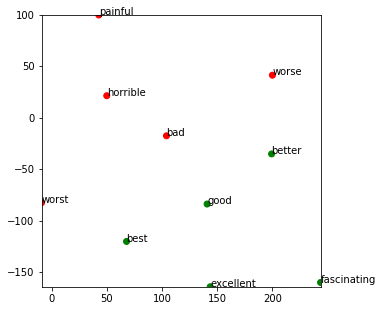

In [8]:
positive_words = ['good', 'better', 'best', 'excellent', 'fascinating']
negative_words = ['bad', 'worse', 'worst', 'horrible', 'painful']
labels = positive_words + negative_words
sentiments = len(positive_words)*['POSITIVE'] + len(negative_words)*['NEGATIVE']
vectors = [word2vec[w] for w in labels]
displaySentimentPlot(labels, sentiments, vectors)

## Define function to compute mean embedding vector of words in translated comment

In [0]:
def mean_vector(comment):
  """returns mean of vector representation words in text.
  returns a vector of zeros if none of the words appear in vocabulary """
  words = [w for w in comment.split() if w in vocabulary] # valid words
  if not words: return np.zeros((embedding_size,), dtype="float32") # no word  
  return np.mean([word2vec[w] for w in words], axis=0)

## Retreive pre-trained model for sentiment classification
- **First upload the file "SA.model.weights.hdf5" containing pre-trained weights for a neural net.**

In [13]:
# This model is a single layered neural network 
# trained using IMDB sentiment analysis data set.

def getSAmodel(weights_file):
  """Returns trained single layered network"""
  model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(300,)),
      tf.keras.layers.Dense(32, activation=tf.nn.relu),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(2, activation=tf.nn.softmax)])
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  model.load_weights(weights_file)
  return model

weights_file = "SA.model.weights.hdf5" 
model = getSAmodel(weights_file)
print("Pre-trained model:")
model.summary()

Pre-trained model:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                9632      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 66        
Total params: 9,698
Trainable params: 9,698
Non-trainable params: 0
_________________________________________________________________


## Define function to classify comment

In [0]:
def sentiment_polarity(comment):
  """returns sentiment polarity and mean vector for comment """
  mean_v = mean_vector(translate(comment))
  return model.predict(np.array([mean_v]))[0][1], mean_v

## Classify user specified comment

In [19]:
comment = input("Type in a comment (in any language): ") # input comment in any language
score, _ = sentiment_polarity(comment) # compute polarity score
sentiment = 'POSITIVE' if score > 0.5 else 'NEGATIVE'
print("\nYour comment: \'%s\' \n\texpresses a %s sentiment \n\t(score = %4.4f)"
     %(comment, sentiment, score))

Type in a comment (in any language): I fear this boring workshop will drag on for another hour

Your comment: 'I fear this boring workshop will drag on for another hour' 
	expresses a NEGATIVE sentiment 
	(score = 0.0000)
